In [7]:

#import libraries and modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from boruta import BorutaPy
import joblib
import numpy as np
import time
import gc



# I have split the Churn dataset into train and test. Have set the test data aside. Will be used later to predict on the undeen data to ensure the quality of the final model


In [ ]:

# Let's take 350 records of the input dataset and set them aside as test set 

random_state = 42
test_size = 350
train_data, test_data = train_test_split(df_churn, test_size=test_size, random_state=random_state)



In [ ]:

#Let's save a copy of train and test datasets

train_data.to_csv('/Users/chidam_sp/Desktop/churn_traindata.csv', index=False)
test_data.to_csv('/Users/chidam_sp/Desktop/churn_testdata.csv', index=False)


In [25]:
#Read in the training data
train_data = pd.read_csv('/Users/chidam_sp/Desktop/churn_traindata.csv')


In [4]:
#Let's check the percentage of null values in the input data

train_data.isnull().sum()*100/len(train_data)


CustomerID                     0.000000
Churn                          0.000000
Tenure                         4.659091
PreferredLoginDevice           0.000000
CityTier                       0.000000
WarehouseToHome                4.356061
PreferredPaymentMode           0.000000
Gender                         0.000000
HourSpendOnApp                 4.545455
NumberOfDeviceRegistered       0.000000
PreferedOrderCat               0.000000
SatisfactionScore              0.000000
MaritalStatus                  0.000000
NumberOfAddress                0.000000
Complain                       0.000000
OrderAmountHikeFromlastYear    4.696970
CouponUsed                     4.602273
OrderCount                     4.545455
DaySinceLastOrder              5.359848
CashbackAmount                 0.000000
dtype: float64

In [5]:
#Total number of columns
len(train_data.columns)

20


## Dynamically designed the process of imputing the missing values - KNN
Goal is to use KNN (K-Nearest Neighbor algorithm) to impute the missing values in the train_data. The algorithm primarily depends on finding neighbors.


In [119]:

#This CV loop here is for KNN - to find the nearest neighbor further to impute the missing values in the training data
def cv_knn(df, nsplit, date, version):
    X = df.copy()
    X.drop(["PreferredPaymentMode", "PreferedOrderCat", "MaritalStatus"], axis=1, inplace=True)
    cv_result = defaultdict(list)
    kf = StratifiedKFold(n_splits=nsplit, shuffle=True)
    f_open = open(f'CV log file to find the best neighbor for KNN - {date} - {version}.txt','a')
    start = time.time()
    y = X["Churn"]
    X.drop("Churn", axis=1, inplace=True)
    avg_f1 = []
    scaler = StandardScaler()
    for n in range(3, 13):
        element_average = []
        for i, (train_index, val_index) in enumerate(kf.split(X, y)):
            x_train = X.loc[train_index]
            x_val = X.loc[val_index]
            y_train = y[train_index]
            y_val = y[val_index]
            x_train = scaler.fit_transform(x_train)
            x_val = scaler.fit_transform(x_val)
            train_imputer = KNNImputer(n_neighbors=n, weights='uniform', metric='nan_euclidean')
            xtrain_imputed = train_imputer.fit_transform(x_train)
            val_imputer = KNNImputer(n_neighbors=3, weights='uniform', metric='nan_euclidean')
            xval_imputed = val_imputer.fit_transform(x_val)
            model = RandomForestClassifier(max_depth=12, random_state=2076)            
            model.fit(xtrain_imputed, y_train)    
            y_pred = model.predict(xval_imputed)            
            f1_value = round(f1_score(y_val, y_pred), 2)
            element_average.append(f1_value)
            cv_result[n].append(f1_value)
        avg_f1.append(round(sum(element_average)/len(element_average), 2))
    max_value = max(cv_result.values())
    max_keys = [k for k, v in cv_result.items() if v == max_value] # getting all keys containing the `maximum`
    f_open.write('                                                  \n')
    f_open.write('##################################################\n')
    f_open.write("The cv_result is {}\n".format(cv_result))
    f_open.write('                                                  \n')
    f_open.write('##################################################\n')
    f_open.write("The best neighbor is {}\n".format(max_keys))
    f_open.write('                                                  \n')
    f_open.write('##################################################\n')
    f_open.write("The average f1_score is {}\n".format(round(sum(avg_f1)/len(avg_f1), 2)))
    f_open.write('                                                  \n')
    f_open.write('##################################################\n')
    f_open.write("Total time taken {}\n".format(str(time.time() - start)))
    f_open.close()
    return max_keys


In [121]:

#Few helper functions to help with the feature engineering process.
def frequency_encoding(df, c):
    freq_encoding = (df.groupby(c).size()) / len(df)
    df[c] = df[c].apply(lambda x : freq_encoding[x])
    return df   

def feature_encoding(X, c):
    encoder = OneHotEncoder(sparse_output=False)
    onehotlabels = encoder.fit_transform(X[[c]])
    df_onehot = pd.DataFrame(onehotlabels)
    for col in df_onehot.columns:
        df_onehot.rename(columns = {col:str(col)+'_'+c}, inplace=True)
    X = pd.concat([X, df_onehot], axis=1)
    X.drop(c, axis=1, inplace=True)
    return X


#This function imputes the missing values in the training data using the neighbors selected from the function cv_knn. 
def feature_engineering_cv(df, date, version, model_name):
    x = df.copy()
    x.columns = x.columns.str.strip()
    x.drop("CustomerID", axis=1, inplace=True)
    avg_f1_score = []
    decimals = 2
    # Imputing only the 0s in Tenure
    x['Tenure'] = x.apply(lambda row: 0.5 if row['Tenure']==0.0 else row['Tenure'], axis=1)
    x["PreferredLoginDevice"] = x["PreferredLoginDevice"].replace(to_replace=['Mobile Phone'], value='Phone')
    x["PreferredPaymentMode"] = x["PreferredPaymentMode"].map({"Debit Card": "debit", "Credit Card": "credit", "E wallet": "wallet", "UPI": "upi", "COD": "cash_delivery", "CC": "credit", "Cash on Delivery": "cash_delivery"})
    x["PreferedOrderCat"] = x["PreferedOrderCat"].replace(to_replace=['Mobile Phone', "Laptop & Accessory"], value=['Mobile', "Laptop_accessory"])
    x['WarehouseToHome'] = x.apply(lambda row: np.nan if row['WarehouseToHome']>120 else row['WarehouseToHome'], axis=1)
    x = feature_encoding(x, "PreferredLoginDevice")
    x = feature_encoding(x, "Gender")
    x["Complain"].replace(to_replace=1, value=-1, inplace=True)
    x["CityTier"] = x["CityTier"].map({1: 3, 2: 2, 3:1})   
    x["CityTier"] = x["CityTier"].astype('int32')
    x["Complain"] = x["Complain"].astype('int32')
    x["NumberOfDeviceRegistered"] = x["NumberOfDeviceRegistered"].astype('int32')
    x["SatisfactionScore"] = x["SatisfactionScore"].astype('int32')
    x["NumberOfAddress"] = x["NumberOfAddress"].astype('int32')
    x["OrderAmountHikeFromlastYear"] = x["OrderAmountHikeFromlastYear"].astype('float32')
    x["CashbackAmount"] = x["CashbackAmount"].astype('float32')
    x.drop('1_Gender', axis=1, inplace=True)
    # Imputing missing values in WarehouseToHome, HourSpendOnApp, OrderAmountHikeFromlastYear, CouponUsed, OrderCount, DaySinceLastOrder, 
    #Tenure
    nneighbors = cv_knn(x, 5, date, model_name)
    y = x["Churn"]
    x.drop("Churn", axis=1, inplace=True)
    X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.05, stratify=y, shuffle=True, random_state=2098)
    X_train = frequency_encoding(X_train, "PreferredPaymentMode")
    X_val = frequency_encoding(X_val, "PreferredPaymentMode")
    X_train = frequency_encoding(X_train, "PreferedOrderCat")
    X_val = frequency_encoding(X_val, "PreferedOrderCat")
    X_train = frequency_encoding(X_train, "MaritalStatus")
    X_val = frequency_encoding(X_val, "MaritalStatus")
    X_train["PreferredPaymentMode"] = X_train["PreferredPaymentMode"].apply(lambda x: round(x, decimals))
    X_train["MaritalStatus"] = X_train["MaritalStatus"].apply(lambda x: round(x, decimals))
    X_train["PreferedOrderCat"] = X_train["PreferedOrderCat"].apply(lambda x: round(x, decimals))
    X_train.drop('PreferedOrderCat', axis=1, inplace=True)
    X_val.drop('PreferedOrderCat', axis=1, inplace=True)
    train_imputer = KNNImputer(n_neighbors=nneighbors[0], weights='uniform', metric='nan_euclidean')
    xtrain_imputed = train_imputer.fit_transform(X_train)
    val_imputer = KNNImputer(n_neighbors=3, weights='uniform', metric='nan_euclidean')
    xval_imputed = val_imputer.fit_transform(X_val)
    # smt = SMOTETomek(sampling_strategy='minority', random_state=3050)
    # xtrain_resampled, ytrain_resampled = smt.fit_resample(xtrain_imputed, y_train)
    return xtrain_imputed, xval_imputed, y_train, y_val, X_train.columns.to_list()


In [122]:

x_train, xval, y_train, yval, column_list = feature_engineering_cv(train_data, "Jan 8", "v11", "Dropping 1_Gender and PreferedOrderCat_rounding float values")




In [72]:
#len of training data - x_train
len(x_train)


5016

In [59]:
#len of y_train
len(y_train)


5016

In [60]:
#Spread of Churn in y_train

y_train.value_counts(dropna=False)


Churn
0    4176
1     840
Name: count, dtype: int64

In [61]:
#Spread of the target variable Churn in validation data

yval.value_counts(dropna=False)


Churn
0    220
1     44
Name: count, dtype: int64

In [62]:
#len of the chosen validation data

len(xval)


264

In [63]:
#Check the len of the selected columns after each transformation
len(column_list)

17

In [123]:
#List of finalized features 
column_list

['Tenure',
 'CityTier',
 'WarehouseToHome',
 'PreferredPaymentMode',
 'HourSpendOnApp',
 'NumberOfDeviceRegistered',
 'SatisfactionScore',
 'MaritalStatus',
 'NumberOfAddress',
 'Complain',
 'OrderAmountHikeFromlastYear',
 'CouponUsed',
 'OrderCount',
 'DaySinceLastOrder',
 'CashbackAmount',
 '0_PreferredLoginDevice',
 '1_PreferredLoginDevice',
 '0_Gender']

In [124]:

#This function involves tuning the hyperparameters part of the ML model-building process.
def hyperparameter_tuning(x_train, xval, y_train, yval, model, param_grid, num_iterations, nsplit, title, version, col_list):
    start = time.time()
    random_cv_result = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=num_iterations,
                            scoring=make_scorer(f1_score, average='binary'), cv=nsplit, refit=True, random_state=1098, verbose=0, return_train_score=True)
    rfc_fitted = random_cv_result.fit(x_train, y_train)
    d = rfc_fitted.cv_results_
    rf_best_estimator = rfc_fitted.best_estimator_
    importances = rf_best_estimator.feature_importances_
    featureimp_df = pd.DataFrame({'features':col_list, 'importance':importances})
    featureimp_df["importance"] = featureimp_df["importance"]/100
    featureimp_df.sort_values(by="importance", ascending=False, inplace=True)
    # Random Forest's Feature Importance
    plt.title("Random Forest's Feature Importance")
    plt.xlabel('Feature importance in percentage')
    plt.ylabel('Features')
    sns.barplot(x='importance', y='features', data=featureimp_df, hue=featureimp_df['features'], legend=False, palette='viridis')
    figuresave_name1 = 'Feature_Importance'+'_'+title+'_'+version+'.png'
    plt.savefig(figuresave_name1, bbox_inches='tight')
    # define Boruta feature selection method
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=0, random_state=42)
    boruta_forest = feat_selector.fit(x_train, y_train)
    feature_ranks = boruta_forest.ranking_
    # Map rankings to column names
    feature_ranking = {col_list[i]: rank for i, rank in enumerate(feature_ranks)}
    # Convert to DataFrame
    Boruta_ranking_df = pd.DataFrame(list(feature_ranking.items()), columns=['Feature', 'Rank'])
    # Sort the DataFrame by rank
    Boruta_ranking_df.sort_values(by='Rank', ascending=False, inplace=True)
    f_open = open(f'Randomized_Search_CV_feature_importance - {title} - {version}.txt','a')
    f_open.write('                                                  \n')
    f_open.write("Parameters tried: {}\n".format(param_grid))
    f_open.write('                                                  \n')
    f_open.write("Best score reached: {}\n".format(round(rfc_fitted.best_score_, 2)))
    f_open.write('                                                  \n')
    f_open.write("Best parameters: {}\n".format(rfc_fitted.best_params_))
    f_open.write('                                                  \n')
    f_open.write("Average of mean validation score is {}\n".format(np.mean(d['mean_test_score'])))
    f_open.write('                                                  \n')
    f_open.write("Average of mean train score is {}\n".format(np.mean(d['mean_train_score'])))
    f_open.write('                                                  \n')
    f_open.write("Average standard deviation validation score is {}\n".format(np.mean(d['std_test_score'])))
    f_open.write('                                                  \n')
    f_open.write("Average standard deviation train score is {}\n".format(np.mean(d['std_train_score'])))
    f_open.write('                                                  \n')
    f_open.write('##################################################\n')
    f_open.write('                                                  \n')
    f_open.write("Feature importance using Random Forest's feature_importances_ {}\n".format(importances))
    f_open.write('                                                  \n')
    f_open.write('##################################################\n')
    f_open.write('                                                  \n')
    f_open.write("Feature importance using Boruta {}\n".format(boruta_forest.n_features_))
    f_open.write('                                                  \n')
    f_open.write("Weak features using Boruta {}\n".format(boruta_forest.support_weak_))
    f_open.write('                                                  \n')
    f_open.write("Selected features using Boruta {}\n".format(boruta_forest.support_))
    f_open.write('                                                  \n')
    f_open.write("Feature ranking using Boruta {}\n".format(boruta_forest.ranking_))
    f_open.write('                                                  \n')
    f_open.write('##################################################\n')
    f_open.write('                                                  \n')
    f_open.write("confusion_matrix is\n {}".format(confusion_matrix(yval.values, rf_best_estimator.predict(xval))))
    f_open.write('                                                  \n')
    f_open.write('##################################################\n')
    f_open.write('                                                  \n')
    f_open.write("Total time taken {}\n".format(str(time.time() - start)))
    f_open.write('                                                  \n')
    # Feature Importance using Boruta
    plt.title("Feature Importance using Boruta")
    plt.xlabel('Rank of the Features')
    plt.ylabel('Feature')
    sns.barplot(x='Rank', y='Feature', data=Boruta_ranking_df, hue=Boruta_ranking_df['Feature'], legend=False, palette='viridis')
    figuresave_name2 = 'Feature_Importance using Boruta'+'_'+title+'_'+version+'.png'
    plt.savefig(figuresave_name2, bbox_inches='tight')
    f_open.close()
    return d
    

In [126]:

param_grid = {'n_estimators': [13, 14, 15, 16, 17, 18, 19, 20], 'max_depth': [11, 12, 13, 14, 15, 16, 17], 'min_samples_split': [5, 6, 7, 8, 9, 10],
             'min_samples_leaf': [3, 4, 5]
             }
clf_rfc = RandomForestClassifier(random_state=2098)
num_iterations = 20
nsplit = 5



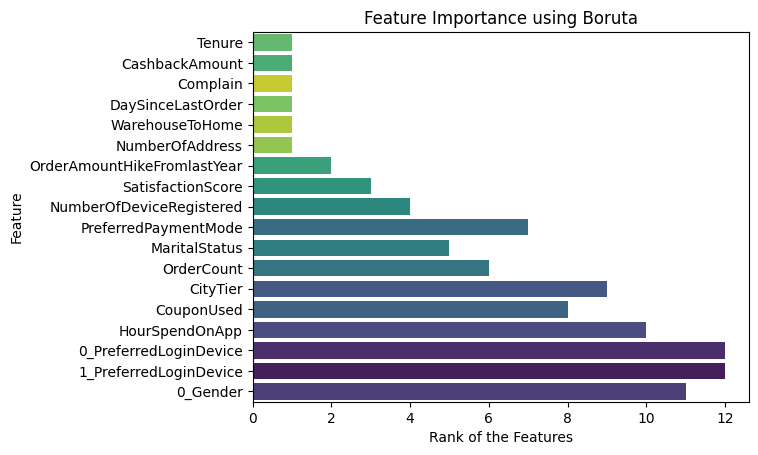

In [127]:

# The outcome of Feature Importance using Boruta is shown here - plots are saved separately, and log files are also created to record the progress
randomizedCv_results = hyperparameter_tuning(x_train, xval, y_train, yval, clf_rfc, param_grid, num_iterations, nsplit, "Dropping 1_Gender and PreferedOrderCat_rounding float values", 'version17',
                                            column_list)




# This function here cv_knn2 is the same as the function above cv_knn but without the statement:
X.drop(["PreferredPaymentMode", "PreferedOrderCat", "MaritalStatus"], axis=1, inplace=True)

I am re-using the function here by assigning a different variable name after removing that statement so it would not break things anywhere else.


In [168]:


def cv_knn2(df, nsplit, date, version):
    X = df.copy()
    # X.drop(["PreferredPaymentMode", "PreferedOrderCat", "MaritalStatus"], axis=1, inplace=True)
    cv_result = defaultdict(list)
    kf = StratifiedKFold(n_splits=nsplit, shuffle=True) 
    f_open = open(f'CV log file to find the best neighbor for KNN - {date} - {version}.txt','a')
    start = time.time()
    y = X["Churn"]
    X.drop("Churn", axis=1, inplace=True)
    avg_f1 = []
    scaler = StandardScaler()
    for n in range(3, 13):
        element_average = []
        for i, (train_index, val_index) in enumerate(kf.split(X, y)):
            x_train = X.loc[train_index]
            x_val = X.loc[val_index]
            y_train = y[train_index]
            y_val = y[val_index]
            x_train = scaler.fit_transform(x_train)
            x_val = scaler.fit_transform(x_val)
            train_imputer = KNNImputer(n_neighbors=n, weights='uniform', metric='nan_euclidean')
            xtrain_imputed = train_imputer.fit_transform(x_train)
            val_imputer = KNNImputer(n_neighbors=3, weights='uniform', metric='nan_euclidean')
            xval_imputed = val_imputer.fit_transform(x_val)
            model = RandomForestClassifier(max_depth=12, random_state=2076)            
            model.fit(xtrain_imputed, y_train)    
            y_pred = model.predict(xval_imputed)            
            f1_value = round(f1_score(y_val, y_pred), 2)
            element_average.append(f1_value)
            cv_result[n].append(f1_value)
        avg_f1.append(round(sum(element_average)/len(element_average), 2))
    max_value = max(cv_result.values())
    max_keys = [k for k, v in cv_result.items() if v == max_value] # getting all keys containing the `maximum`
    f_open.write('                                                  \n')
    f_open.write('##################################################\n')
    f_open.write("The cv_result is {}\n".format(cv_result))
    f_open.write('                                                  \n')
    f_open.write('##################################################\n')
    f_open.write("The best neighbor is {}\n".format(max_keys))
    f_open.write('                                                  \n')
    f_open.write('##################################################\n')
    f_open.write("The average f1_score is {}\n".format(round(sum(avg_f1)/len(avg_f1), 2)))
    f_open.write('                                                  \n')
    f_open.write('##################################################\n')
    f_open.write("Total time taken {}\n".format(str(time.time() - start)))
    f_open.close()
    return max_keys



# Goal: To create the final dataset for Grid Search process to discover the best estimator and parameters
This function here feature_engineering_cv2 is the same as the above one feature_engineering_cv but without splitting the imputed, transformed data into train and validation sets.  


In [169]:


def feature_engineering_cv2(df, date, version, model_name):
    x = df.copy()
    x.columns = x.columns.str.strip()
    x.drop("CustomerID", axis=1, inplace=True)
    avg_f1_score = []
    # Imputing only the 0s in Tenure
    x['Tenure'] = x.apply(lambda row: 0.5 if row['Tenure']==0.0 else row['Tenure'], axis=1)
    x["PreferredLoginDevice"] = x["PreferredLoginDevice"].replace(to_replace=['Mobile Phone'], value='Phone')
    x["PreferredPaymentMode"] = x["PreferredPaymentMode"].map({"Debit Card": "debit", "Credit Card": "credit", "E wallet": "wallet", "UPI": "upi", "COD": "cash_delivery", "CC": "credit", "Cash on Delivery": "cash_delivery"})
    x["PreferedOrderCat"] = x["PreferedOrderCat"].replace(to_replace=['Mobile Phone', "Laptop & Accessory"], value=['Mobile', "Laptop_accessory"])
    x['WarehouseToHome'] = x.apply(lambda row: np.nan if row['WarehouseToHome']>120 else row['WarehouseToHome'], axis=1)
    x = feature_encoding(x, "PreferredLoginDevice")
    x = feature_encoding(x, "Gender")
    x = frequency_encoding(x, "PreferredPaymentMode")
    x = frequency_encoding(x, "PreferedOrderCat")
    x = frequency_encoding(x, "MaritalStatus")
    x["Complain"].replace(to_replace=1, value=-1, inplace=True)
    x["CityTier"] = x["CityTier"].map({1: 3, 2: 2, 3:1})   
    x["CityTier"] = x["CityTier"].astype('int32')
    x["Complain"] = x["Complain"].astype('int32')
    x["NumberOfDeviceRegistered"] = x["NumberOfDeviceRegistered"].astype('int32')
    x["SatisfactionScore"] = x["SatisfactionScore"].astype('int32')
    x["NumberOfAddress"] = x["NumberOfAddress"].astype('int32')
    x["OrderAmountHikeFromlastYear"] = x["OrderAmountHikeFromlastYear"].astype('float32')
    x["CashbackAmount"] = x["CashbackAmount"].astype('float32')
    x["PreferredPaymentMode"] = x["PreferredPaymentMode"].astype('float64')
    x["PreferedOrderCat"] = x["PreferedOrderCat"].astype('float64')
    x["MaritalStatus"] = x["MaritalStatus"].astype('float64')
    x.drop("PreferedOrderCat", axis=1, inplace=True)
    x.drop("1_Gender", axis=1, inplace=True)
    # Imputing missing values in WarehouseToHome, HourSpendOnApp, OrderAmountHikeFromlastYear, CouponUsed, OrderCount, DaySinceLastOrder, 
    #Tenure
    nneighbors = cv_knn2(x, 5, date, model_name)
    y = x["Churn"]
    x.drop("Churn", axis=1, inplace=True)
    train_imputer = KNNImputer(n_neighbors=nneighbors[0], weights='uniform', metric='nan_euclidean')
    xtrain_imputed = train_imputer.fit_transform(x)
    df_xtrain_imputed = pd.DataFrame.from_records(xtrain_imputed, columns=x.columns.to_list())
    df_xtrain_imputed['Churn'] = y
    return df_xtrain_imputed
    


In [144]:
#Getting the final transformed data
df_xtrain_final = feature_engineering_cv2(train_data, 'Jan_8', 'v3', "Getting the final transformed train dataset for grid search")


In [145]:
#Few records to review
df_xtrain_final.head()


,Tenure,CityTier,WarehouseToHome,PreferredPaymentMode,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,0_PreferredLoginDevice,1_PreferredLoginDevice,0_Gender,Churn
0,0.5,2.0,14.0,0.072348,2.0,4.0,5.0,0.532008,5.0,-1.0,15.0,1.000000,2.0,0.0,123.0,0.0,1.0,0.0,1
1,25.0,1.0,33.0,0.107576,4.0,4.0,3.0,0.149053,4.0,0.0,15.0,1.333333,5.0,18.0,288.0,0.0,1.0,1.0,0
2,1.0,3.0,23.0,0.412500,3.0,2.0,3.0,0.532008,5.0,0.0,17.0,2.000000,2.0,8.0,178.0,0.0,1.0,0.0,0
3,12.0,3.0,17.0,0.315530,4.0,4.0,3.0,0.532008,2.0,0.0,18.0,1.000000,2.0,3.0,152.0,1.0,0.0,0.0,0
4,24.0,1.0,27.0,0.107576,3.0,3.0,1.0,0.318939,1.0,-1.0,22.0,0.000000,1.0,0.0,154.0,0.0,1.0,0.0,0


In [147]:

df_xtrain_final.columns


Index(['Tenure', 'CityTier', 'WarehouseToHome', 'PreferredPaymentMode',
       'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore',
       'MaritalStatus', 'NumberOfAddress', 'Complain',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount', '0_PreferredLoginDevice',
       '1_PreferredLoginDevice', '0_Gender', 'Churn'],
      dtype='object')


# From EDA, we have gathered that correlation is an issue to watch out for.
Here, the function find_95_correlated identifies the features that are more than 95% correlated in the dataset.


In [242]:

#Let's see which features are more than 95% correlated

def find_95_correlated(df):
    # Create correlation matrix
    corr_matrix = df.corr()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
    # Find index of feature columns with correlation greater than 0.95
    col_95_correlation = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]
    return col_95_correlation




In [243]:
#features are more than 95% correlated
find_95_correlated(df_xtrain_imputed)


['1_PreferredLoginDevice', '1_Gender']


## Deal with Multicollinearity using the Variance Inflation Factor concept from statsmodels


In [100]:

#Copy the data to not break things around
df_vif = df_xtrain_imputed.copy()


In [101]:

#Drop the target variable before using Variance Inflation Factor
df_vif.drop("Churn", axis=1, inplace=True)


In [102]:

def VIF(df):
    df_const = sm.add_constant(df, prepend = False)
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(df_const.values, i) for i in range(df_const.shape[1])]
    vif["features"] = df_const.columns
    return vif


In [103]:

VIF(df_vif)


/Users/chidam_sp/Library/Python/3.9/lib/python/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/chidam_sp/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,VIF Factor,features
0,1.411176,Tenure
1,1.091138,CityTier
2,1.011906,WarehouseToHome
3,1.082073,PreferredPaymentMode
4,1.269646,HourSpendOnApp
5,1.169657,NumberOfDeviceRegistered
6,4.297530,PreferedOrderCat
7,1.016924,SatisfactionScore
8,1.010235,MaritalStatus
9,1.141521,NumberOfAddress



# Observation
Features such as CashbackAmount and PreferedOrderCat showcase a VIF factor above value 4. We could drop one of these and repeat the tuning process in the function hyperparameter_tuning to check for any improvement in the model's performance.




# GridSearchCV to select the best model with the best set of hyperparameters
This is the final phase of tuning. After this the final model is ready to predict on the unseen data, i.e., test data.


In [157]:


def grid_search(x, column, model, param_grid, n_split):
    x_grid = x.copy()
    y_grid = x_grid[column]
    x_grid.drop(column, axis=1, inplace=True)
    start = time.time()
    f_open = open(f'Log file for grid search.txt','a')
    grid_search_result = GridSearchCV(estimator=model, param_grid=param_grid, cv=n_split, scoring=make_scorer(f1_score, average='binary'))
    grid_search_result.fit(x_grid, y_grid)
    joblib.dump(grid_search_result.best_estimator_, 'churn_model_for_zooominfo_project.pkl')
    print("Final Churn Model is successfully saved!")
    f_open.write('                                                  \n')
    f_open.write('##################################################\n')
    f_open.write("The best parameters are {}\n".format(grid_search_result.best_params_))
    f_open.write('                                                  \n')
    f_open.write('##################################################\n')
    f_open.write("Mean cross-validated score of the best_estimator is {}\n".format(grid_search_result.best_score_))
    f_open.write('                                                  \n')
    f_open.write('##################################################\n')
    f_open.write("Names of features seen during fit are {}\n".format(grid_search_result.feature_names_in_))
    f_open.write('                                                  \n')
    f_open.write('##################################################\n')
    f_open.write("Total time taken {}\n".format(str(time.time() - start)))
    f_open.close()
    return grid_search_result
    

In [158]:

gridsearch_param_grid = {
    'max_depth': [12, 13, 14, 15],
    'min_samples_split': [8, 9, 10, 11, 12],
    'n_estimators': [12, 13, 14, 15, 16, 17],
    'min_samples_leaf': [3, 4, 5],
    'max_features': [9, 10, 11, 12]
}
clf_rfc_grid = RandomForestClassifier(random_state=2098)
n_split_grid = 5
grid_search_result = grid_search(df2, "Churn", clf_rfc_grid, gridsearch_param_grid, n_split_grid)


Final Churn Model is successfully saved!



# Best parameetrs selected through the function: grid_search


In [159]:


grid_search_result.best_params_


{'max_depth': 13,
 'max_features': 9,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 17}


# The best estimator selected through grid search


In [162]:

grid_search_result.best_estimator_


RandomForestClassifier(max_depth=13, max_features=9, min_samples_leaf=3,
                       min_samples_split=8, n_estimators=17, random_state=2098)


# Mean cross-validated score of the best_estimator


In [165]:

grid_search_result.best_score_


0.7776813234474537


## Transform the test data before finding the predictions


In [161]:
#Read in the test data

test_data = pd.read_csv('/Users/chidam_sp/Desktop/churn_testdata.csv')


In [176]:

df_test1 = test_data.copy()



In [178]:

test_df = feature_engineering_cv2(df_test1, 'Jan 8', 'v1', 'Final RFC_Churn')



In [179]:

#Test data after the feature transformations
test_df


,Tenure,CityTier,WarehouseToHome,PreferredPaymentMode,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,0_PreferredLoginDevice,1_PreferredLoginDevice,0_Gender,Churn
0,1.0,1.0,7.0,0.080000,4.0,6.0,5.0,0.320000,2.0,0.0,22.0,2.0,2.00,1.0,148.0,1.0,0.0,1.0,1
1,15.0,3.0,9.0,0.388571,3.0,1.0,1.0,0.505714,3.0,-1.0,13.0,1.0,1.00,3.0,152.0,0.0,1.0,1.0,0
2,13.0,3.0,29.0,0.308571,3.0,4.0,5.0,0.320000,3.0,-1.0,14.0,2.0,4.50,9.0,234.0,1.0,0.0,1.0,0
3,5.0,3.0,7.0,0.388571,4.0,5.0,5.0,0.505714,3.0,0.0,13.0,4.0,4.00,3.0,147.0,0.0,1.0,0.0,0
4,13.0,3.0,7.0,0.388571,4.0,5.0,1.0,0.505714,3.0,0.0,17.0,10.0,7.25,9.0,252.0,0.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,3.0,3.0,34.0,0.308571,4.0,4.0,3.0,0.174286,6.0,0.0,13.0,2.0,2.00,2.0,168.0,0.0,1.0,1.0,0
346,15.0,3.0,14.0,0.388571,2.0,3.0,3.0,0.320000,5.0,0.0,13.0,1.0,1.00,0.0,140.0,0.0,1.0,0.0,0
347,4.0,1.0,12.0,0.388571,3.0,4.0,2.0,0.174286,4.0,0.0,13.0,3.0,8.00,7.5,219.0,0.0,1.0,1.0,0
348,17.0,1.0,6.0,0.131429,3.0,3.0,3.0,0.174286,8.0,0.0,12.0,1.0,1.00,0.0,148.0,1.0,0.0,1.0,0


In [181]:

#Spread of the target variable in the test data
test_df["Churn"].value_counts(dropna=False)


Churn
0    286
1     64
Name: count, dtype: int64


## Prediction function to predict on unseen data using the best random forest classifier(RFC) estimator selected through the function grid_search


In [195]:

def final_predictions(df, model, date, version, model_name):
    df_test = df.copy()
    start = time.time()
    f_open = open(f'Final Predictions - {model_name} - {version}.txt','a')
    test_y = df_test["Churn"]
    df_test.drop("Churn", axis=1, inplace=True)
    y_pred_test = model.predict(df_test.values)            
    f1_score_test = round(f1_score(test_y, y_pred_test), 2)
    precision_test, recall_test, thresholds_test = precision_recall_curve(test_y, y_pred_test)
    f_open.write('                                                  \n')
    f_open.write('##################################################\n')
    f_open.write("Final f1_score on test data is {}\n".format(f1_score_test))
    f_open.write('                                                  \n')
    f_open.write('##################################################\n')
    f_open.write("confusion_matrix for test data is\n {}".format(confusion_matrix(test_y, y_pred_test)))
    f_open.write('                                                  \n')
    f_open.write('##################################################\n')
    f_open.write("The Precision for test data is {}\n".format(precision_test))
    f_open.write('                                                  \n')
    f_open.write("The Recall for test data is {}\n".format(recall_test))
    f_open.write('                                                  \n')
    f_open.write("The thresholds for test data is {}\n".format(thresholds_test))
    f_open.write('##################################################\n')
    f_open.write('                                                  \n')
    f_open.write("Total time taken {}\n".format(str(time.time() - start)))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for test data')
    plt.plot(recall_test, precision_test, label='Precision-Recall curve')     
    figuresave_name_test = 'Precision-Recall Curve'+'_'+model_name+date+'_'+version+'.png'
    plt.savefig(figuresave_name_test)
    f_open.close()
    return f1_score_test
    
    



## Precision-Recall Curve for the test data showcasing the best-trained model's performance


/Users/chidam_sp/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


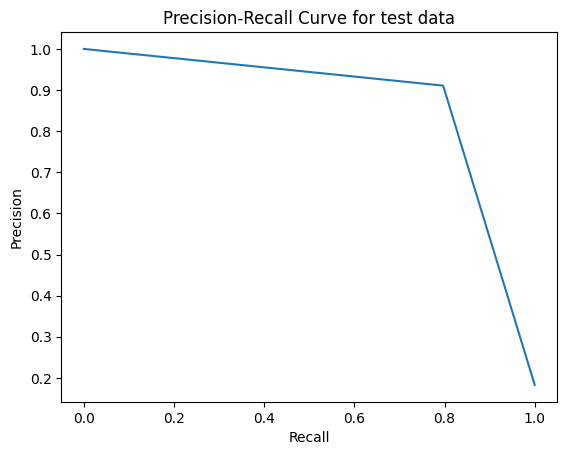

In [196]:

f1_score_test = final_predictions(test_df, grid_search_result.best_estimator_, 'Jan 8', 'prediction_version', "RFC_for_churn")
